<a href="https://colab.research.google.com/github/hemsush/PPMDashboard/blob/master/c02_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima --q # for auto arima
!pip install prophet --q # for fbprophet

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 24.7 MB/s 


In [71]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
# Linear Regression
from sklearn.linear_model import LinearRegression
# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8); # setting the figuresize 

from datetime import datetime, date #Library to deal with datetime columns

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Neural network required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#for saving trained model
import pickle

import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

In [3]:
!pip install openpyxl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/test/CO2_dataset.xlsx')

Mounted at /content/drive


In [5]:
df.head()

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    float64
 1   CO2     215 non-null    float64
dtypes: float64(2)
memory usage: 3.5 KB


In [7]:
df.duplicated().sum()

0

In [8]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [9]:
df.set_index(['Year'], inplace=True)

In [10]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [11]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [12]:
if (df.index.max() - df.index.min() == 214): 
    print('Data Is Continuous')

In [13]:
df.index.freq='YS'

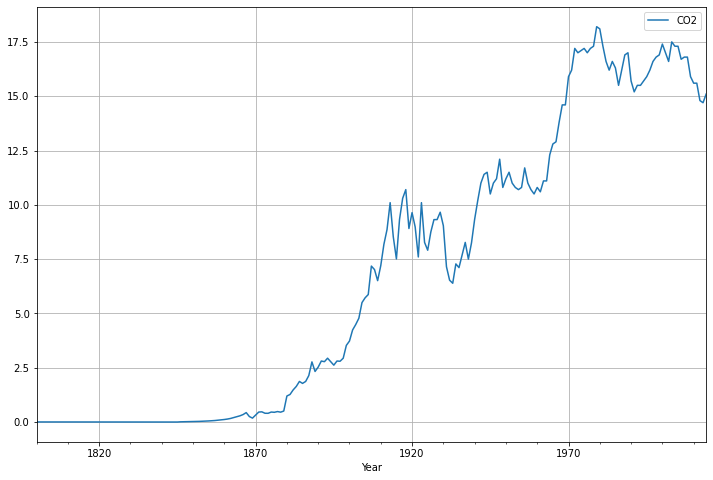

In [14]:
df.plot(grid=True);

In [15]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

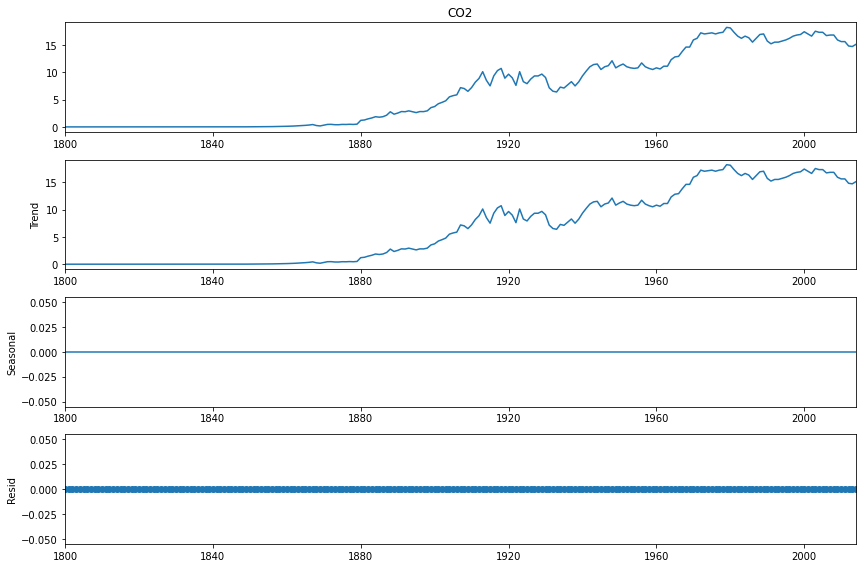

In [16]:
  decompose_add = seasonal_decompose(df['CO2'])
  decompose_add.plot();

In [17]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [18]:
diff_df = df.diff() #first differencing for stationarity
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [19]:
diff_df.dropna(inplace=True) 

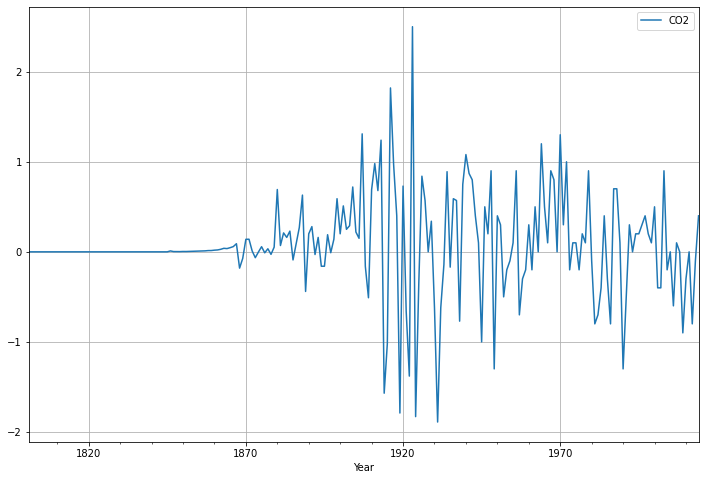

In [20]:
diff_df.plot(grid=True);

In [21]:
adf_test(diff_df)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


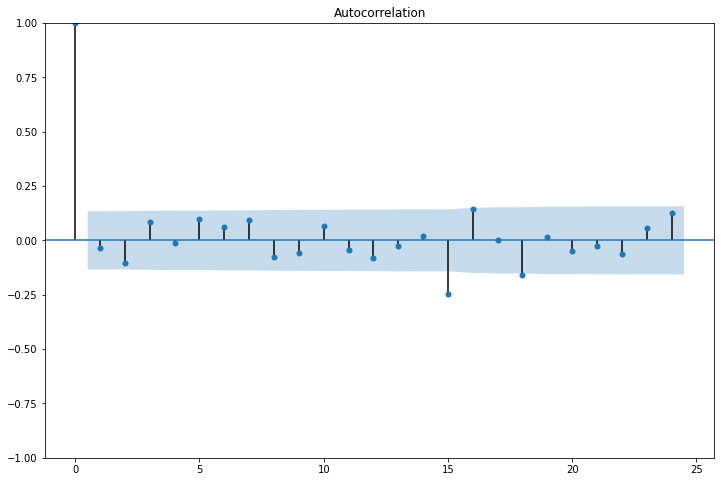

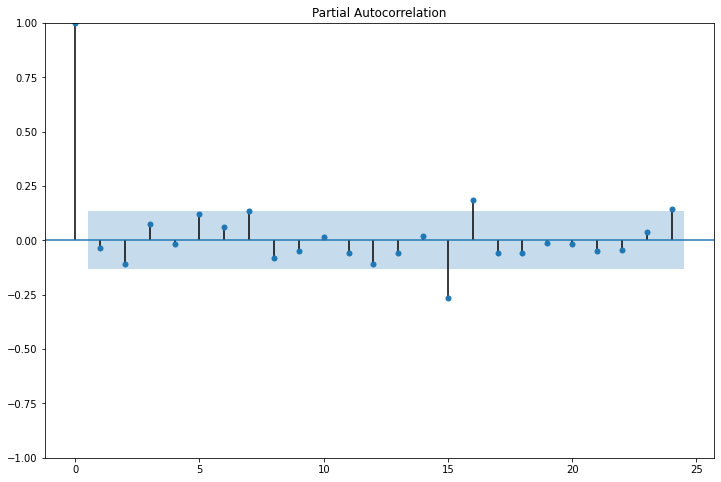

In [22]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df);
plot_pacf(diff_df);

**Time series Forecasting - Single Exponential Smoothing**

In [23]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

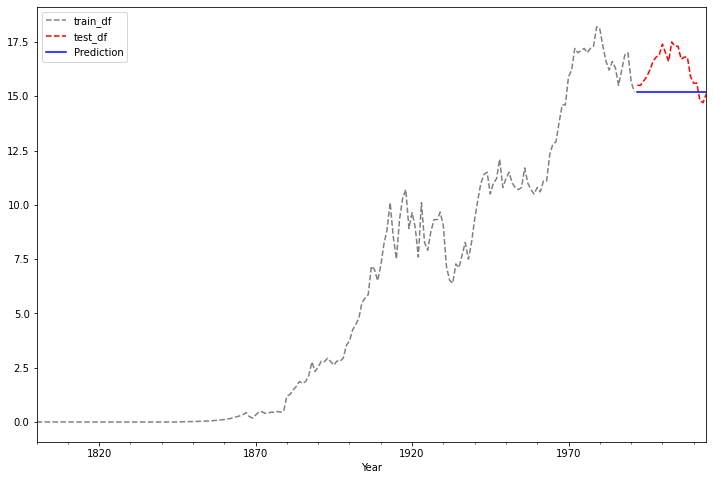

In [24]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [25]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 0.5646920026800116
Test RMSE: 1.342911302270165
Train MAPE: 0.08470530767414804
Test MAPE: 0.06861466412077383


**DES**

In [26]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

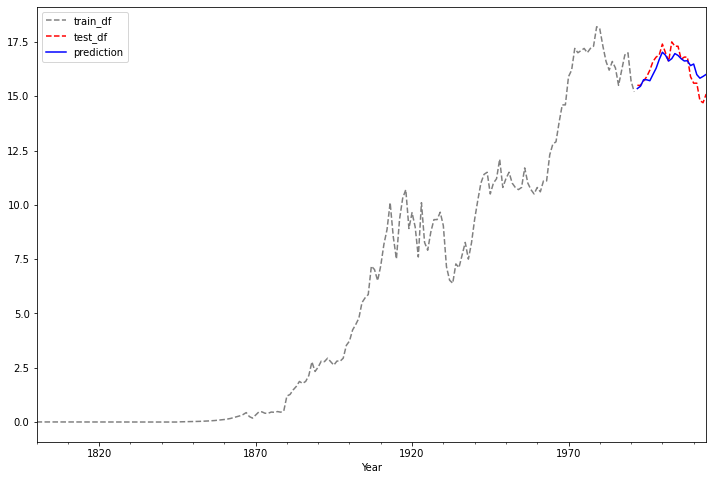

In [27]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [28]:
print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE: 0.5219963052653047
Test RMSE: 0.5352720574221986
Train MAPE: 12.80676949834386
Test MAPE: 0.026063825837478335


TES

In [29]:
hw_model = ExponentialSmoothing(train_df['CO2'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=28, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(23)

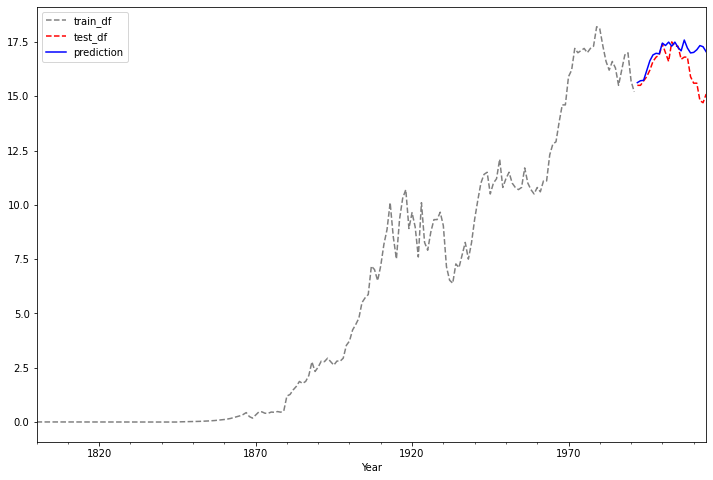

In [30]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [31]:
print('Train RMSE:',mean_squared_error(train_df, hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, hw_test_pred))

Train RMSE: 0.5106136819354261
Test RMSE: 1.0377035674553476
Train MAPE: 14.258480781249787
Test MAPE: 0.044712190954021055


**ARIMA**

In [32]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

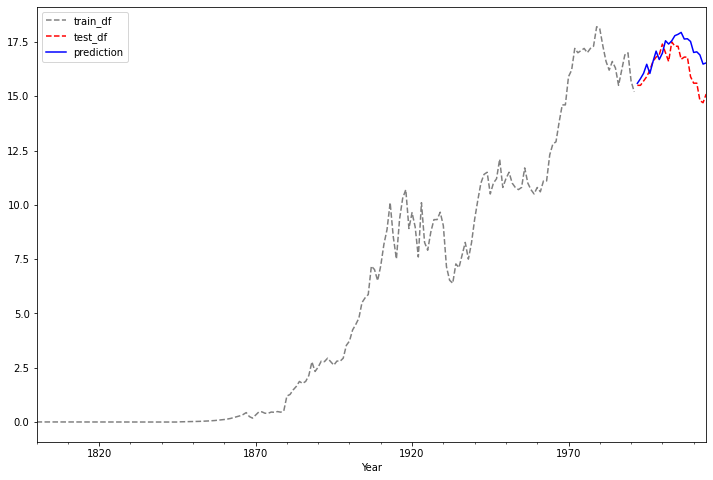

In [33]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

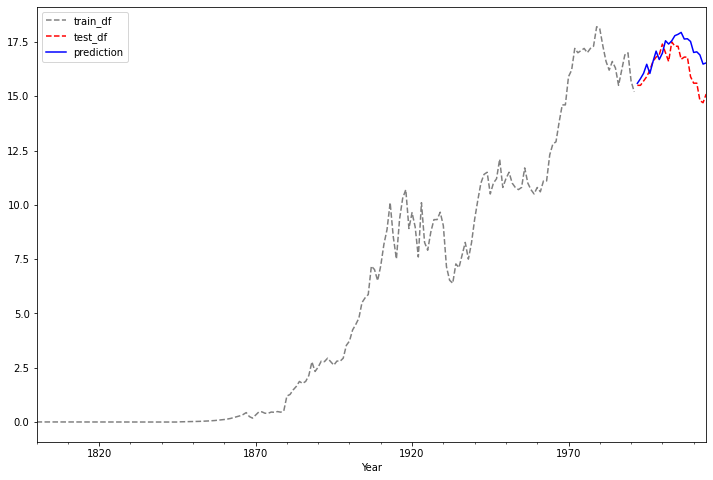

In [34]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [35]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.4678055845540344
Test RMSE: 0.9697085294865194
Train MAPE: 0.08142094478005486
Test MAPE: 0.04814172762040949


# Grid Search

In [36]:
def evaluate_arima_model(arima_order):
    # prepare training dataset
    train_df = df.loc[:'1991-01-01']
    test_df = df.loc['1992-01-01':]
    # make predictions
    model = ARIMA(train_df, order=arima_order).fit()
    model_pred = model.forecast(23)
    rmse = (mean_squared_error(test_df, model_pred)**0.5)
    return rmse

In [37]:
def evaluate_models(dataset, p_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for q in q_values:
				order = (p,1,q)
				try:
					rmse = evaluate_arima_model(order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [38]:
p_values = [7,15,16,24]
q_values = [15,16,18]

evaluate_models(df['CO2'].values, p_values, q_values)

Best ARIMA(16, 1, 16) RMSE=0.788


In [39]:
arima = ARIMA(train_df['CO2'], order=(16,1,16)).fit()
arima_train_pred = arima.predict()
arima_test_pred = arima.forecast(23)

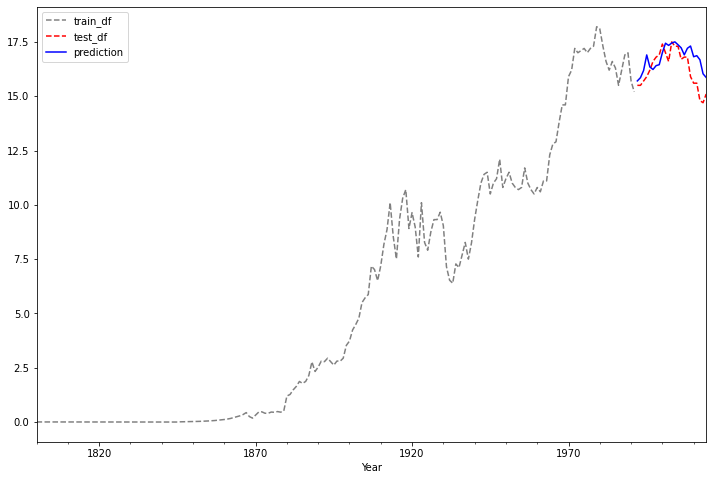

In [40]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [41]:
print('Train RMSE:',mean_squared_error(train_df, arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, arima_test_pred))

Train RMSE: 0.45791547238679126
Test RMSE: 0.7875833887833542
Train MAPE: 0.08105251237386481
Test MAPE: 0.039144125911325656


# Auto Arima- SARIMA

In [42]:
auto_arima(df['CO2'], m=30, max_order= None, max_p=16, max_q=16, max_d=1,max_P=16, max_Q=16, max_D=2, maxiter=50, alpha=0.05, n_jobs=-1,information_criterion='aic', out_of_sample_size=30).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  215
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 30)   Log Likelihood                -171.435
Date:                            Sun, 09 Oct 2022   AIC                            348.870
Time:                                    11:20:00   BIC                            358.968
Sample:                                         0   HQIC                           352.950
                                            - 215                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0539      0.037      1.437      0.151      -0.020       0.127
ar.S.L30       0.1737      0.063      2.743      0.006       0.050       0.298
sigma2         0.2895      0.016     17.659      0.000       0.257       0.322
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               134.27
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              73.27   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# pass the order and seasonal order values we got from auto arima
sarima = SARIMAX(train_df['CO2'], order=(0,1,0), seasonal_order=(1,0,0,30)).fit()
sarima_train_pred = sarima.predict()
sarima_test_pred = sarima.forecast(23)

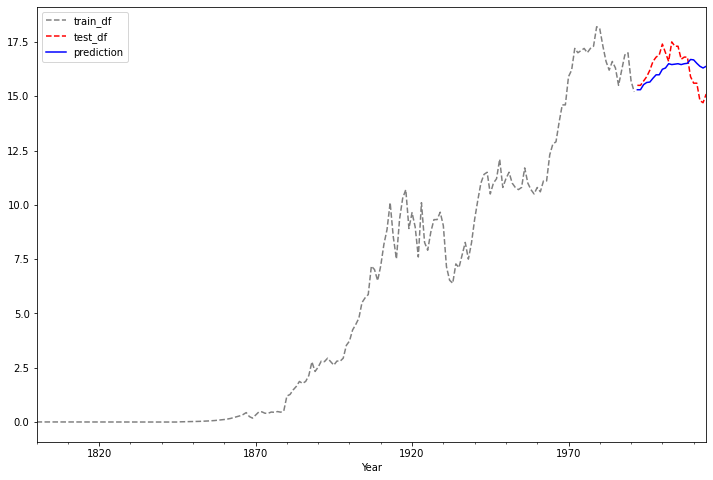

In [44]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
sarima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

# Univariate  analysis

In [45]:
prophet_df = df.copy()
prophet_df.reset_index(inplace=True)
prophet_df.columns=['ds','y']
prophet_df.head()

,ds,y
0,1800-01-01,0.00568
1,1801-01-01,0.00561
2,1802-01-01,0.00555
3,1803-01-01,0.00548
4,1804-01-01,0.00542


In [46]:
prophet_train_df = prophet_df.iloc[:-23]
prophet_test_df = prophet_df.iloc[-23:]

In [47]:
prophet_model = Prophet()
prophet_model.fit(prophet_train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps658vz1y/7fw4gtqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps658vz1y/dxoifw_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89055', 'data', 'file=/tmp/tmps658vz1y/7fw4gtqk.json', 'init=/tmp/tmps658vz1y/dxoifw_n.json', 'output', 'file=/tmp/tmps658vz1y/prophet_modeldi1gq1sm/prophet_model-20221009112451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:24:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
future = prophet_model.make_future_dataframe(periods=23, freq='YS')
prophet_predictions = prophet_model.predict(future)

In [49]:
prophet_predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
210,2010-01-01,19.682824,18.471219,21.300788,19.541468,19.844600,0.198590,0.198590,0.198590,0.198590,0.198590,0.198590,0.0,0.0,0.0,19.881414
211,2011-01-01,19.824644,18.786033,21.746011,19.672966,19.998533,0.423988,0.423988,0.423988,0.423988,0.423988,0.423988,0.0,0.0,0.0,20.248632
212,2012-01-01,19.966463,19.187573,22.039153,19.801045,20.150967,0.649965,0.649965,0.649965,0.649965,0.649965,0.649965,0.0,0.0,0.0,20.616428
213,2013-01-01,20.108671,18.527254,21.589789,19.929648,20.305034,-0.025953,-0.025953,-0.025953,-0.025953,-0.025953,-0.025953,0.0,0.0,0.0,20.082719
214,2014-01-01,20.250491,19.039146,21.880484,20.055959,20.459872,0.198590,0.198590,0.198590,0.198590,0.198590,0.198590,0.0,0.0,0.0,20.449081


In [50]:
plot_plotly(prophet_model, prophet_predictions)

In [51]:
prophet_train_df['prophet_train_pred'] = prophet_predictions.iloc[:-23]['yhat']
prophet_test_df['prophet_test_pred'] = prophet_predictions.iloc[-23:]['yhat']

In [52]:
print('Train RMSE:',mean_squared_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred'])**0.5)
print('Test RMSE:',mean_squared_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred'])**0.5)
print('Train MAPE:',mean_absolute_percentage_error(prophet_train_df['y'], prophet_train_df['prophet_train_pred']))
print('Test MAPE:',mean_absolute_percentage_error(prophet_test_df['y'], prophet_test_df['prophet_test_pred']))

Train RMSE: 1.1146903013208278
Test RMSE: 3.0635913850989684
Train MAPE: 19.288955819123846
Test MAPE: 0.1714044701145226


# LSTM

In [53]:
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y)

In [54]:
x, y = df_to_x_y(df['CO2'], 29)
x.shape, y.shape

((186, 29, 1), (186,))

In [60]:
x_train_df, y_train_df = x[:-23], y[:-23]
x_test_df, y_test_df = x[-23:], y[-23:]
x_train_df.shape, y_train_df.shape, x_test_df.shape, y_test_df.shape

((163, 29, 1), (163,), (23, 29, 1), (23,))

In [61]:
lstm = Sequential()
lstm.add(InputLayer((29,1)))
lstm.add(LSTM(20))
lstm.add(Dense(10,'relu'))
lstm.add(Dense(5,'relu'))
lstm.add(Dense(1,'linear'))

lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                1760      
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,031
Trainable params: 2,031
Non-trainable params: 0
_________________________________________________________________


In [62]:
cp1 = ModelCheckpoint('lstm/', save_best_only=True)
lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

In [63]:
lstm.fit(x_train_df, y_train_df, epochs=100, callbacks=[cp1])

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 33.3085 - root_mean_squared_error: 5.7714 

6/6 [==============================] - 2s 15ms/step - loss: 32.7159 - root_mean_squared_error: 5.7198
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 4.0670 - root_mean_squared_error: 2.0167

6/6 [==============================] - 0s 15ms/step - loss: 4.0284 - root_mean_squared_error: 2.0071
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 1.0460 - root_mean_squared_error: 1.0227

6/6 [==============================] - 0s 15ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.9202 - root_mean_squared_error: 0.9593

6/6 [==============================] - 0s 15ms/step - loss: 0.9394 - root_mean_squared_error: 0.9692
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6775 - root_mean_squared_error: 0.8231

6/6 [==============================] - 0s 14ms/step - loss: 0.6735 - root_mean_squared_error: 0.8206
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4707 - root_mean_squared_error: 0.6861

6/6 [==============================] - 0s 13ms/step - loss: 0.4626 - root_mean_squared_error: 0.6801
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4264 - root_mean_squared_error: 0.6530

6/6 [==============================] - 0s 15ms/step - loss: 0.4345 - root_mean_squared_error: 0.6592
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 1.1637 - root_mean_squared_error: 1.0787

6/6 [==============================] - 0s 13ms/step - loss: 1.1637 - root_mean_squared_error: 1.0787
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 1.0841 - root_mean_squared_error: 1.0412

6/6 [==============================] - 0s 15ms/step - loss: 1.0704 - root_mean_squared_error: 1.0346
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 0.7645 - root_mean_squared_error: 0.8743

6/6 [==============================] - 0s 13ms/step - loss: 0.7645 - root_mean_squared_error: 0.8743
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.8271 - root_mean_squared_error: 0.9095

6/6 [==============================] - 0s 15ms/step - loss: 0.8218 - root_mean_squared_error: 0.9065
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 0.5498 - root_mean_squared_error: 0.7415

6/6 [==============================] - 0s 14ms/step - loss: 0.5498 - root_mean_squared_error: 0.7415
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 0.4787 - root_mean_squared_error: 0.6919

6/6 [==============================] - 0s 13ms/step - loss: 0.4787 - root_mean_squared_error: 0.6919
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4400 - root_mean_squared_error: 0.6633

6/6 [==============================] - 0s 15ms/step - loss: 0.4327 - root_mean_squared_error: 0.6578
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3697 - root_mean_squared_error: 0.6080

6/6 [==============================] - 0s 16ms/step - loss: 0.3687 - root_mean_squared_error: 0.6072
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3473 - root_mean_squared_error: 0.5893

6/6 [==============================] - 0s 14ms/step - loss: 0.3623 - root_mean_squared_error: 0.6019
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 1.5449 - root_mean_squared_error: 1.2429

6/6 [==============================] - 0s 14ms/step - loss: 1.5288 - root_mean_squared_error: 1.2364
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 1.1055 - root_mean_squared_error: 1.0514

6/6 [==============================] - 0s 15ms/step - loss: 1.0871 - root_mean_squared_error: 1.0426
Epoch 19/100
6/6 [==============================] - ETA: 0s - loss: 0.6352 - root_mean_squared_error: 0.7970

6/6 [==============================] - 0s 13ms/step - loss: 0.6352 - root_mean_squared_error: 0.7970
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4420 - root_mean_squared_error: 0.6648

6/6 [==============================] - 0s 14ms/step - loss: 0.4460 - root_mean_squared_error: 0.6678
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3938 - root_mean_squared_error: 0.6275

6/6 [==============================] - 0s 14ms/step - loss: 0.3899 - root_mean_squared_error: 0.6244
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4348 - root_mean_squared_error: 0.6594

6/6 [==============================] - 0s 16ms/step - loss: 0.4276 - root_mean_squared_error: 0.6539
Epoch 23/100
6/6 [==============================] - ETA: 0s - loss: 0.6002 - root_mean_squared_error: 0.7747

6/6 [==============================] - 0s 14ms/step - loss: 0.6002 - root_mean_squared_error: 0.7747
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.9426 - root_mean_squared_error: 0.9709

6/6 [==============================] - 0s 15ms/step - loss: 0.9333 - root_mean_squared_error: 0.9661
Epoch 25/100
6/6 [==============================] - ETA: 0s - loss: 1.1586 - root_mean_squared_error: 1.0764

6/6 [==============================] - 0s 13ms/step - loss: 1.1586 - root_mean_squared_error: 1.0764
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 1.2069 - root_mean_squared_error: 1.0986

6/6 [==============================] - 0s 15ms/step - loss: 1.2025 - root_mean_squared_error: 1.0966
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.7249 - root_mean_squared_error: 0.8514

6/6 [==============================] - 0s 14ms/step - loss: 0.7121 - root_mean_squared_error: 0.8439
Epoch 28/100
6/6 [==============================] - ETA: 0s - loss: 0.6081 - root_mean_squared_error: 0.7798

6/6 [==============================] - 0s 14ms/step - loss: 0.6081 - root_mean_squared_error: 0.7798
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6467 - root_mean_squared_error: 0.8042

6/6 [==============================] - 0s 15ms/step - loss: 0.6393 - root_mean_squared_error: 0.7996
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5874 - root_mean_squared_error: 0.7664

6/6 [==============================] - 0s 15ms/step - loss: 0.5787 - root_mean_squared_error: 0.7607
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3715 - root_mean_squared_error: 0.6095

6/6 [==============================] - 0s 14ms/step - loss: 0.3716 - root_mean_squared_error: 0.6096
Epoch 32/100
6/6 [==============================] - ETA: 0s - loss: 0.5091 - root_mean_squared_error: 0.7135

6/6 [==============================] - 0s 14ms/step - loss: 0.5091 - root_mean_squared_error: 0.7135
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5259 - root_mean_squared_error: 0.7252

6/6 [==============================] - 0s 14ms/step - loss: 0.5551 - root_mean_squared_error: 0.7451
Epoch 34/100
6/6 [==============================] - ETA: 0s - loss: 0.4214 - root_mean_squared_error: 0.6491

6/6 [==============================] - 0s 13ms/step - loss: 0.4214 - root_mean_squared_error: 0.6491
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 2.1277 - root_mean_squared_error: 1.4587

6/6 [==============================] - 0s 15ms/step - loss: 2.1434 - root_mean_squared_error: 1.4640
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 2.2630 - root_mean_squared_error: 1.5043

6/6 [==============================] - 0s 16ms/step - loss: 2.2440 - root_mean_squared_error: 1.4980
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 1.4349 - root_mean_squared_error: 1.1979

6/6 [==============================] - 0s 14ms/step - loss: 1.4340 - root_mean_squared_error: 1.1975
Epoch 38/100
6/6 [==============================] - ETA: 0s - loss: 0.9289 - root_mean_squared_error: 0.9638

6/6 [==============================] - 0s 13ms/step - loss: 0.9289 - root_mean_squared_error: 0.9638
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6774 - root_mean_squared_error: 0.8231

6/6 [==============================] - 0s 15ms/step - loss: 0.6693 - root_mean_squared_error: 0.8181
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5587 - root_mean_squared_error: 0.7474

6/6 [==============================] - 0s 14ms/step - loss: 0.5571 - root_mean_squared_error: 0.7464
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4972 - root_mean_squared_error: 0.7051

6/6 [==============================] - 0s 14ms/step - loss: 0.4905 - root_mean_squared_error: 0.7004
Epoch 42/100
4/6 [===================>..........] - ETA: 0s - loss: 0.4120 - root_mean_squared_error: 0.6418

6/6 [==============================] - 0s 19ms/step - loss: 0.4415 - root_mean_squared_error: 0.6644
Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 1.0090 - root_mean_squared_error: 1.0045

6/6 [==============================] - 0s 13ms/step - loss: 1.0090 - root_mean_squared_error: 1.0045
Epoch 44/100
6/6 [==============================] - ETA: 0s - loss: 2.2162 - root_mean_squared_error: 1.4887

6/6 [==============================] - 0s 14ms/step - loss: 2.2162 - root_mean_squared_error: 1.4887
Epoch 45/100
4/6 [===================>..........] - ETA: 0s - loss: 1.9409 - root_mean_squared_error: 1.3932

6/6 [==============================] - 0s 21ms/step - loss: 2.5102 - root_mean_squared_error: 1.5844
Epoch 46/100
6/6 [==============================] - ETA: 0s - loss: 1.2418 - root_mean_squared_error: 1.1143

6/6 [==============================] - 0s 24ms/step - loss: 1.2418 - root_mean_squared_error: 1.1143
Epoch 47/100
4/6 [===================>..........] - ETA: 0s - loss: 0.9463 - root_mean_squared_error: 0.9728

6/6 [==============================] - 0s 20ms/step - loss: 1.0428 - root_mean_squared_error: 1.0212
Epoch 48/100
4/6 [===================>..........] - ETA: 0s - loss: 0.9179 - root_mean_squared_error: 0.9581

6/6 [==============================] - 0s 23ms/step - loss: 0.8810 - root_mean_squared_error: 0.9386
Epoch 49/100
4/6 [===================>..........] - ETA: 0s - loss: 1.3670 - root_mean_squared_error: 1.1692

6/6 [==============================] - 0s 23ms/step - loss: 1.5138 - root_mean_squared_error: 1.2304
Epoch 50/100
4/6 [===================>..........] - ETA: 0s - loss: 0.6710 - root_mean_squared_error: 0.8192

6/6 [==============================] - 0s 20ms/step - loss: 0.7937 - root_mean_squared_error: 0.8909
Epoch 51/100
4/6 [===================>..........] - ETA: 0s - loss: 0.7140 - root_mean_squared_error: 0.8450

6/6 [==============================] - 0s 21ms/step - loss: 0.8587 - root_mean_squared_error: 0.9267
Epoch 52/100
6/6 [==============================] - ETA: 0s - loss: 0.9108 - root_mean_squared_error: 0.9543

6/6 [==============================] - 0s 28ms/step - loss: 0.9108 - root_mean_squared_error: 0.9543
Epoch 53/100
4/6 [===================>..........] - ETA: 0s - loss: 0.9831 - root_mean_squared_error: 0.9915

6/6 [==============================] - 0s 21ms/step - loss: 0.8612 - root_mean_squared_error: 0.9280
Epoch 54/100
4/6 [===================>..........] - ETA: 0s - loss: 0.4978 - root_mean_squared_error: 0.7056

6/6 [==============================] - 0s 21ms/step - loss: 0.5282 - root_mean_squared_error: 0.7268
Epoch 55/100
4/6 [===================>..........] - ETA: 0s - loss: 0.4663 - root_mean_squared_error: 0.6829

6/6 [==============================] - 0s 21ms/step - loss: 0.4450 - root_mean_squared_error: 0.6671
Epoch 56/100
4/6 [===================>..........] - ETA: 0s - loss: 0.7305 - root_mean_squared_error: 0.8547

6/6 [==============================] - 0s 22ms/step - loss: 0.6624 - root_mean_squared_error: 0.8139
Epoch 57/100
4/6 [===================>..........] - ETA: 0s - loss: 0.5350 - root_mean_squared_error: 0.7314

6/6 [==============================] - 0s 21ms/step - loss: 0.5091 - root_mean_squared_error: 0.7135
Epoch 58/100
4/6 [===================>..........] - ETA: 0s - loss: 0.6607 - root_mean_squared_error: 0.8128

6/6 [==============================] - 0s 19ms/step - loss: 0.6663 - root_mean_squared_error: 0.8163
Epoch 59/100
6/6 [==============================] - ETA: 0s - loss: 0.5168 - root_mean_squared_error: 0.7189

6/6 [==============================] - 0s 23ms/step - loss: 0.5168 - root_mean_squared_error: 0.7189
Epoch 60/100
4/6 [===================>..........] - ETA: 0s - loss: 0.3666 - root_mean_squared_error: 0.6054

6/6 [==============================] - 0s 22ms/step - loss: 0.3773 - root_mean_squared_error: 0.6142
Epoch 61/100
4/6 [===================>..........] - ETA: 0s - loss: 0.3606 - root_mean_squared_error: 0.6005

6/6 [==============================] - 0s 21ms/step - loss: 0.4636 - root_mean_squared_error: 0.6809
Epoch 62/100
4/6 [===================>..........] - ETA: 0s - loss: 0.6117 - root_mean_squared_error: 0.7821

6/6 [==============================] - 0s 22ms/step - loss: 0.7651 - root_mean_squared_error: 0.8747
Epoch 63/100
6/6 [==============================] - ETA: 0s - loss: 0.7222 - root_mean_squared_error: 0.8498

6/6 [==============================] - 0s 14ms/step - loss: 0.7222 - root_mean_squared_error: 0.8498
Epoch 64/100
6/6 [==============================] - ETA: 0s - loss: 0.5194 - root_mean_squared_error: 0.7207

6/6 [==============================] - 0s 13ms/step - loss: 0.5194 - root_mean_squared_error: 0.7207
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4819 - root_mean_squared_error: 0.6942

6/6 [==============================] - 0s 15ms/step - loss: 0.4901 - root_mean_squared_error: 0.7000
Epoch 66/100
6/6 [==============================] - ETA: 0s - loss: 0.5705 - root_mean_squared_error: 0.7553

6/6 [==============================] - 0s 13ms/step - loss: 0.5705 - root_mean_squared_error: 0.7553
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4805 - root_mean_squared_error: 0.6932

6/6 [==============================] - 0s 16ms/step - loss: 0.4750 - root_mean_squared_error: 0.6892
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3586 - root_mean_squared_error: 0.5988

6/6 [==============================] - 0s 14ms/step - loss: 0.3547 - root_mean_squared_error: 0.5956
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3548 - root_mean_squared_error: 0.5957

6/6 [==============================] - 0s 15ms/step - loss: 0.3505 - root_mean_squared_error: 0.5920
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3489 - root_mean_squared_error: 0.5907

6/6 [==============================] - 0s 15ms/step - loss: 0.3439 - root_mean_squared_error: 0.5864
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4893 - root_mean_squared_error: 0.6995

6/6 [==============================] - 0s 17ms/step - loss: 0.4840 - root_mean_squared_error: 0.6957
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6402 - root_mean_squared_error: 0.8001

6/6 [==============================] - 0s 15ms/step - loss: 0.6313 - root_mean_squared_error: 0.7946
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5529 - root_mean_squared_error: 0.7435

6/6 [==============================] - 0s 15ms/step - loss: 0.5444 - root_mean_squared_error: 0.7378
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3121 - root_mean_squared_error: 0.5587

6/6 [==============================] - 0s 14ms/step - loss: 0.3069 - root_mean_squared_error: 0.5540
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5160 - root_mean_squared_error: 0.7183

6/6 [==============================] - 0s 15ms/step - loss: 0.5113 - root_mean_squared_error: 0.7151
Epoch 76/100
6/6 [==============================] - ETA: 0s - loss: 0.4572 - root_mean_squared_error: 0.6762

6/6 [==============================] - 0s 13ms/step - loss: 0.4572 - root_mean_squared_error: 0.6762
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3298 - root_mean_squared_error: 0.5742

6/6 [==============================] - 0s 15ms/step - loss: 0.3237 - root_mean_squared_error: 0.5690
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.2900 - root_mean_squared_error: 0.5385

6/6 [==============================] - 0s 15ms/step - loss: 0.3193 - root_mean_squared_error: 0.5651
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 1.0511 - root_mean_squared_error: 1.0252

6/6 [==============================] - 0s 14ms/step - loss: 1.0381 - root_mean_squared_error: 1.0188
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 1.0259 - root_mean_squared_error: 1.0129

6/6 [==============================] - 0s 15ms/step - loss: 1.0255 - root_mean_squared_error: 1.0127
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 1.2255 - root_mean_squared_error: 1.1070

6/6 [==============================] - 0s 15ms/step - loss: 1.2156 - root_mean_squared_error: 1.1025
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6328 - root_mean_squared_error: 0.7955

6/6 [==============================] - 0s 15ms/step - loss: 0.6541 - root_mean_squared_error: 0.8088
Epoch 83/100
6/6 [==============================] - ETA: 0s - loss: 0.7851 - root_mean_squared_error: 0.8861

6/6 [==============================] - 0s 13ms/step - loss: 0.7851 - root_mean_squared_error: 0.8861
Epoch 84/100
6/6 [==============================] - ETA: 0s - loss: 0.4852 - root_mean_squared_error: 0.6965

6/6 [==============================] - 0s 13ms/step - loss: 0.4852 - root_mean_squared_error: 0.6965
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4294 - root_mean_squared_error: 0.6553

6/6 [==============================] - 0s 14ms/step - loss: 0.4317 - root_mean_squared_error: 0.6570
Epoch 86/100
6/6 [==============================] - ETA: 0s - loss: 0.6175 - root_mean_squared_error: 0.7858

6/6 [==============================] - 0s 13ms/step - loss: 0.6175 - root_mean_squared_error: 0.7858
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5778 - root_mean_squared_error: 0.7601

6/6 [==============================] - 0s 17ms/step - loss: 0.5755 - root_mean_squared_error: 0.7586
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6263 - root_mean_squared_error: 0.7914

6/6 [==============================] - 0s 15ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4327 - root_mean_squared_error: 0.6578

6/6 [==============================] - 0s 15ms/step - loss: 0.4329 - root_mean_squared_error: 0.6580
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4431 - root_mean_squared_error: 0.6656

6/6 [==============================] - 0s 14ms/step - loss: 0.4360 - root_mean_squared_error: 0.6603
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5022 - root_mean_squared_error: 0.7086

6/6 [==============================] - 0s 15ms/step - loss: 0.4995 - root_mean_squared_error: 0.7067
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3947 - root_mean_squared_error: 0.6283

6/6 [==============================] - 0s 14ms/step - loss: 0.3909 - root_mean_squared_error: 0.6252
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4433 - root_mean_squared_error: 0.6658

6/6 [==============================] - 0s 15ms/step - loss: 0.4479 - root_mean_squared_error: 0.6692
Epoch 94/100
6/6 [==============================] - ETA: 0s - loss: 0.3554 - root_mean_squared_error: 0.5961

6/6 [==============================] - 0s 14ms/step - loss: 0.3554 - root_mean_squared_error: 0.5961
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3997 - root_mean_squared_error: 0.6322

6/6 [==============================] - 0s 14ms/step - loss: 0.3944 - root_mean_squared_error: 0.6280
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3682 - root_mean_squared_error: 0.6068

6/6 [==============================] - 0s 15ms/step - loss: 0.3647 - root_mean_squared_error: 0.6039
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.3861 - root_mean_squared_error: 0.6214

6/6 [==============================] - 0s 14ms/step - loss: 0.3853 - root_mean_squared_error: 0.6207
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.4801 - root_mean_squared_error: 0.6929

6/6 [==============================] - 0s 15ms/step - loss: 0.4714 - root_mean_squared_error: 0.6866
Epoch 99/100
4/6 [===================>..........] - ETA: 0s - loss: 0.4545 - root_mean_squared_error: 0.6741

6/6 [==============================] - 0s 17ms/step - loss: 0.4651 - root_mean_squared_error: 0.6819
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.5851 - root_mean_squared_error: 0.7649

6/6 [==============================] - 0s 14ms/step - loss: 0.6046 - root_mean_squared_error: 0.7776


In [64]:
test_predictions = lstm.predict(x_test_df).flatten()
test_df['lstm_pred'] = test_predictions

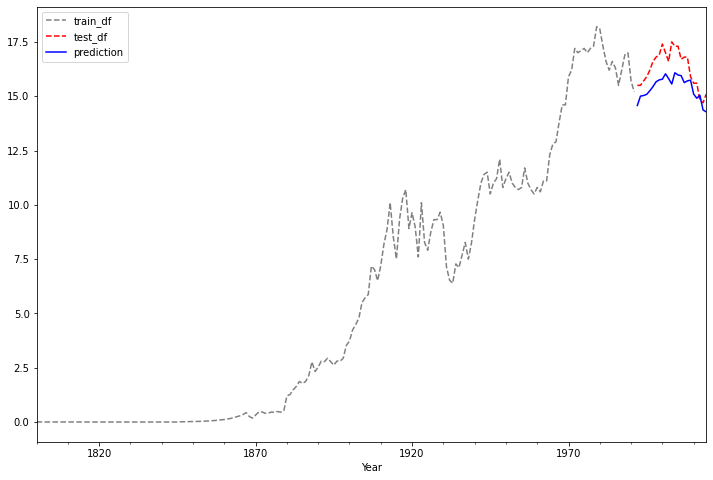

In [65]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
test_df['lstm_pred'].plot(color='b', legend=True, label='prediction')

In [66]:
print('Test RMSE:',mean_squared_error(test_df['CO2'], test_df['lstm_pred'])**0.5)
print('Test MAPE:',mean_absolute_percentage_error(test_df['CO2'], test_df['lstm_pred']))

Test RMSE: 1.000046073762351
Test MAPE: 0.05502352556532039


In [69]:
comparision_df = pd.DataFrame(data=[['SES', 1.3429 , 0.0686],
                           ['DES', 0.5352,  0.0260],
                          ['TES', 1.0377, 0.0447],
                          ['Linear Regression',0.8121,0.0321],
                          ['ARIMA(15,1,15)', 0.9591, 0.0475],
                          ['ARIMA(16,1,16)', 0.8337, 0.0417],
                          ['SARIMA(0,1,0)(1,0,0,30)', 0.8435, 0.0448],
                          ['Holt-winter', 2.9893, 0.1665],
                          ['LSTM', 0.9939, 0.05592]], columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [70]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
DES,0.5352,0.02600
Linear Regression,0.8121,0.03210
"ARIMA(16,1,16)",0.8337,0.04170
"SARIMA(0,1,0)(1,0,0,30)",0.8435,0.04480
"ARIMA(15,1,15)",0.9591,0.04750
LSTM,0.9939,0.05592
TES,1.0377,0.04470
SES,1.3429,0.06860
Holt-winter,2.9893,0.16650


# Linear Regression

In [72]:
x = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010]
y = [123,456,789,12,11,213,123,234,123,199,300]

In [73]:
x_train=np.array(x)
x_test=np.array(x)

In [74]:
y_train=np.array(y)
y_test=np.array(y)

In [75]:
x_train=x_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)

In [76]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [77]:
x_test=x_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [78]:
model.predict(x_test)

array([[306.86363636],
       [292.45454545],
       [278.04545455],
       [263.63636364],
       [249.22727273],
       [234.81818182],
       [220.40909091],
       [206.        ],
       [191.59090909],
       [177.18181818],
       [162.77272727]])